## Рябцев Артем, ИД22-3, Анализ маршрутов полетов авиакомпаний в США

Импортируем нужные библиотеки для работы с данными:

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

Считаем данные и выведем первые 5 строк:

In [92]:
data = pd.read_csv("US Airline Flight Routes and Fares 1993-2024.csv", low_memory=False)

In [93]:
pd.set_option('display.max_columns', None) 
pd.set_option('display.expand_frame_repr', False) 

data.head()

,tbl,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,airportid_1,airportid_2,airport_1,airport_2,nsmiles,passengers,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,Geocoded_City1,Geocoded_City2,tbl1apk
0,Table1a,2021,3,30135,33195,"Allentown/Bethlehem/Easton, PA","Tampa, FL (Metropolitan Area)",10135,14112,ABE,PIE,970,180,81.43,G4,1.0000,81.43,G4,1.0000,81.43,NaN,NaN,202131013514112ABEPIE
1,Table1a,2021,3,30135,33195,"Allentown/Bethlehem/Easton, PA","Tampa, FL (Metropolitan Area)",10135,15304,ABE,TPA,970,19,208.93,DL,0.4659,219.98,UA,0.1193,154.11,NaN,NaN,202131013515304ABETPA
2,Table1a,2021,3,30140,30194,"Albuquerque, NM","Dallas/Fort Worth, TX",10140,11259,ABQ,DAL,580,204,184.56,WN,0.9968,184.44,WN,0.9968,184.44,NaN,NaN,202131014011259ABQDAL
3,Table1a,2021,3,30140,30194,"Albuquerque, NM","Dallas/Fort Worth, TX",10140,11298,ABQ,DFW,580,264,182.64,AA,0.9774,183.09,AA,0.9774,183.09,NaN,NaN,202131014011298ABQDFW
4,Table1a,2021,3,30140,30466,"Albuquerque, NM","Phoenix, AZ",10140,14107,ABQ,PHX,328,398,177.11,WN,0.6061,184.49,AA,0.3939,165.77,NaN,NaN,202131014014107ABQPHX


Посмотрим информацию о датасете:

In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245955 entries, 0 to 245954
Data columns (total 23 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tbl             245955 non-null  object 
 1   Year            245955 non-null  int64  
 2   quarter         245955 non-null  int64  
 3   citymarketid_1  245955 non-null  int64  
 4   citymarketid_2  245955 non-null  int64  
 5   city1           245955 non-null  object 
 6   city2           245955 non-null  object 
 7   airportid_1     245955 non-null  int64  
 8   airportid_2     245955 non-null  int64  
 9   airport_1       245955 non-null  object 
 10  airport_2       245955 non-null  object 
 11  nsmiles         245955 non-null  int64  
 12  passengers      245955 non-null  int64  
 13  fare            245955 non-null  float64
 14  carrier_lg      244415 non-null  object 
 15  large_ms        244415 non-null  float64
 16  fare_lg         244415 non-null  float64
 17  carrier_lo

Видим, что датасет содержит 245955 записей, 23 признака.
На данном этапе необходимо убедиться, что отсутствуют проблемы с типами данных. В данном случае категориальные признаки являются строками, числовые - целыми и вещественными числами. Проблем нет.

Посмотрим на количество дубликатов:

In [95]:
duplicates = data.duplicated().sum()
print(f'Количество дубликатов: {duplicates}')

Количество дубликатов: 0


Далее посмотрим на пропуски в данных:

In [96]:
data.isna().sum()

tbl                   0
Year                  0
quarter               0
citymarketid_1        0
citymarketid_2        0
city1                 0
city2                 0
airportid_1           0
airportid_2           0
airport_1             0
airport_2             0
nsmiles               0
passengers            0
fare                  0
carrier_lg         1540
large_ms           1540
fare_lg            1540
carrier_low        1612
lf_ms              1612
fare_low           1612
Geocoded_City1    39206
Geocoded_City2    39206
tbl1apk               0
dtype: int64

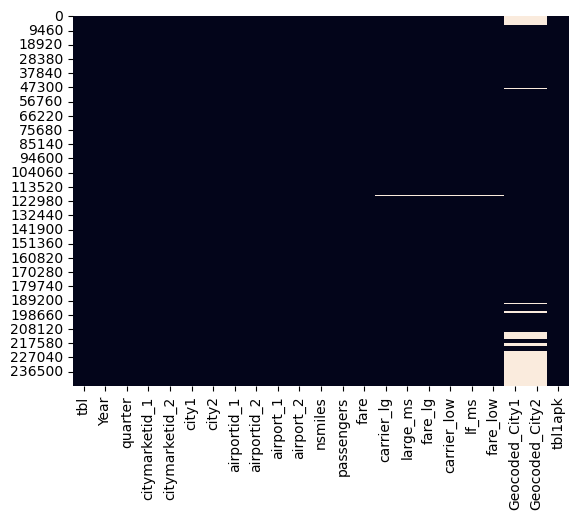

In [97]:
sns.heatmap(data.isnull(), cbar=False)
plt.show()

Можем наблюдать большое количество пропусков по координатам городов. Удалим данный признак, поскольку координаты непосредственно связаны с городом, по городам пропуски отсутствуют.

Также мы видими, что есть пропуски по крупнейшим перевозчикам на данном рейсе, доля рынка крупнейшего оператора, средний тариф крупнейшего перевозчика, перевозчикам с самым низким тарифом, рыночным долям перевозчиков с самым низким тарифом, самым низким тарифам. Мы можем удалить эти записи, поскольку они могут помешать провести анализ. Если удалить 1612 записей, то при общем количестве записей в 245955, мы потеряем менее 1% от всех данных, что не окажет существенного влияния на результат.

In [98]:
data = data.drop(columns=["tbl", "citymarketid_1", "citymarketid_2", "airportid_1", "airportid_2", "Geocoded_City1", "Geocoded_City2", "tbl1apk"])

In [99]:
max(data['fare'])

3377.0

In [100]:
data.head()

,Year,quarter,city1,city2,airport_1,airport_2,nsmiles,passengers,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low
0,2021,3,"Allentown/Bethlehem/Easton, PA","Tampa, FL (Metropolitan Area)",ABE,PIE,970,180,81.43,G4,1.0000,81.43,G4,1.0000,81.43
1,2021,3,"Allentown/Bethlehem/Easton, PA","Tampa, FL (Metropolitan Area)",ABE,TPA,970,19,208.93,DL,0.4659,219.98,UA,0.1193,154.11
2,2021,3,"Albuquerque, NM","Dallas/Fort Worth, TX",ABQ,DAL,580,204,184.56,WN,0.9968,184.44,WN,0.9968,184.44
3,2021,3,"Albuquerque, NM","Dallas/Fort Worth, TX",ABQ,DFW,580,264,182.64,AA,0.9774,183.09,AA,0.9774,183.09
4,2021,3,"Albuquerque, NM","Phoenix, AZ",ABQ,PHX,328,398,177.11,WN,0.6061,184.49,AA,0.3939,165.77


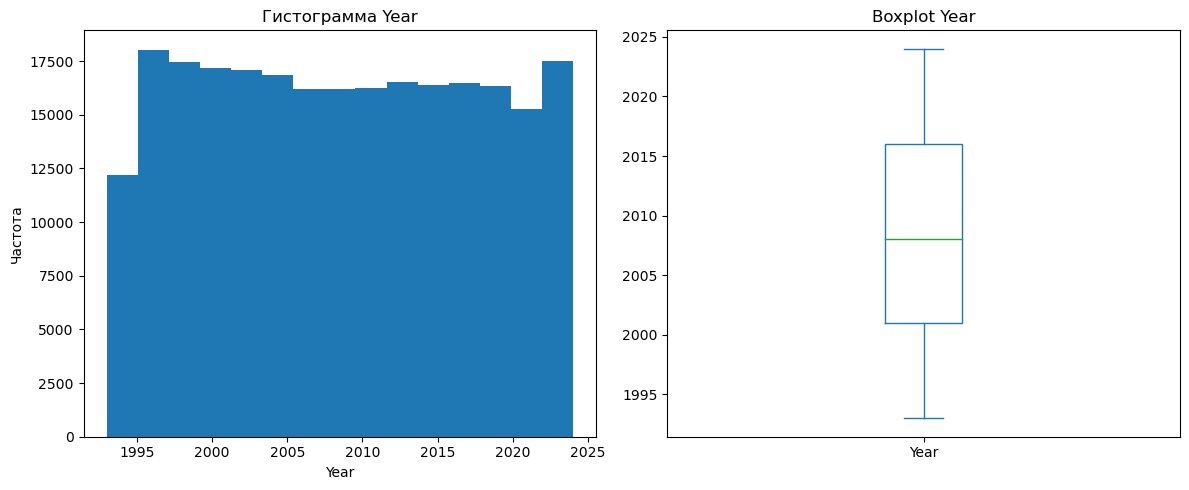

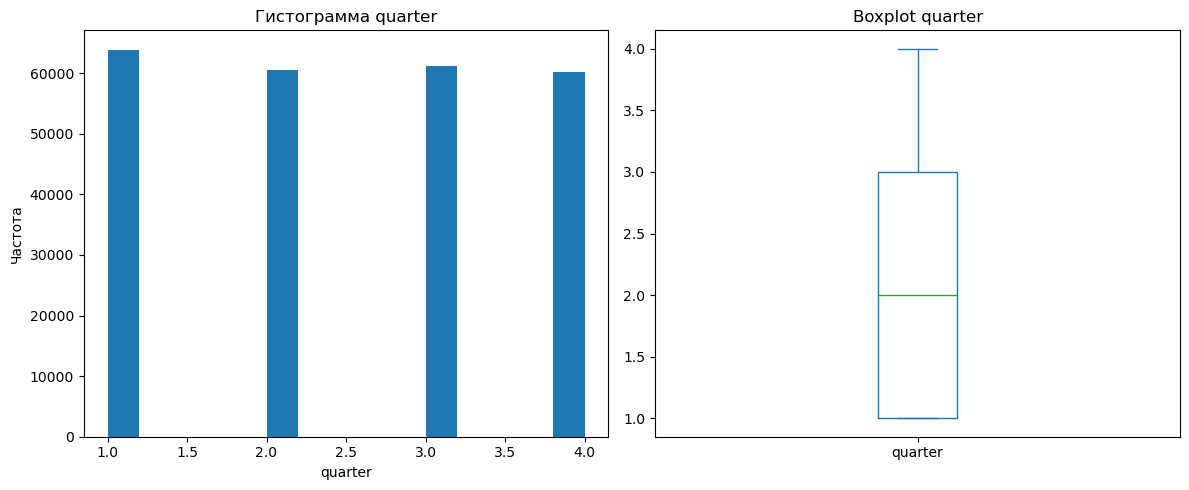

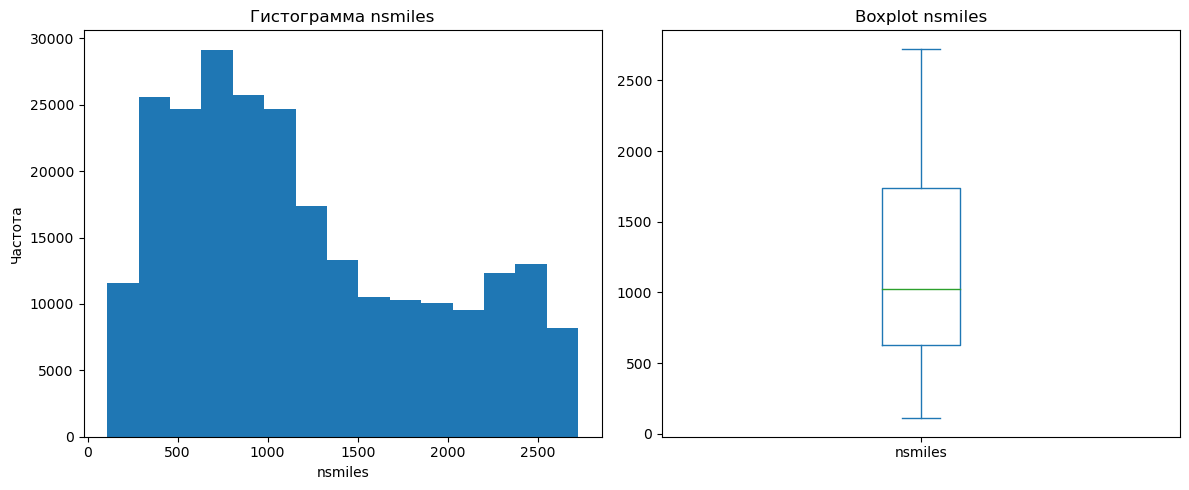

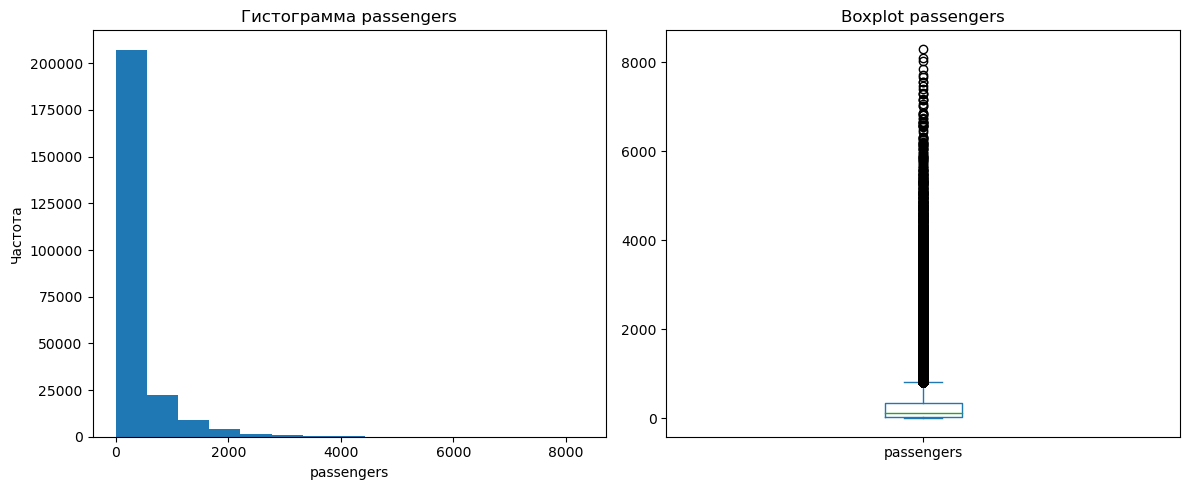

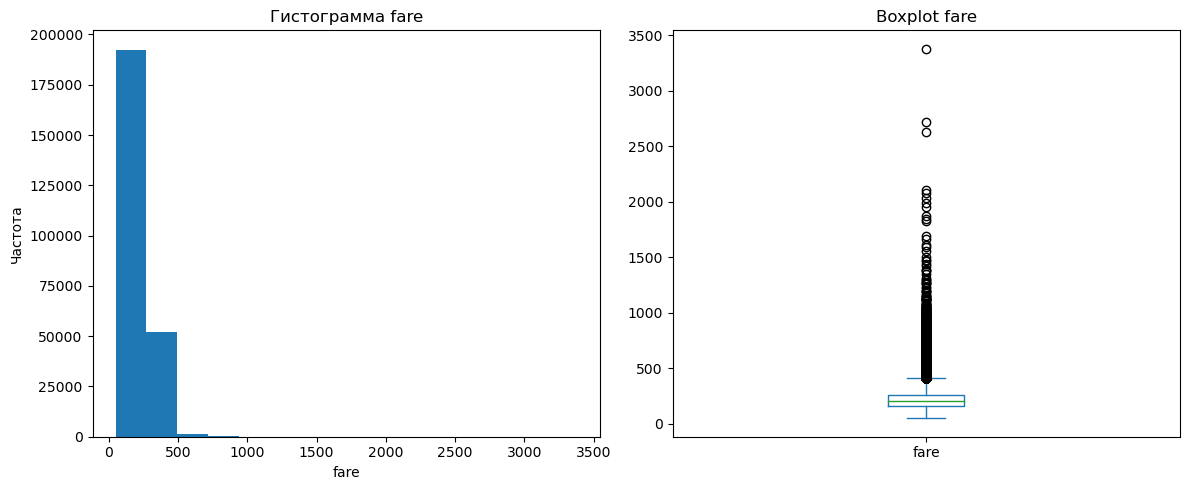

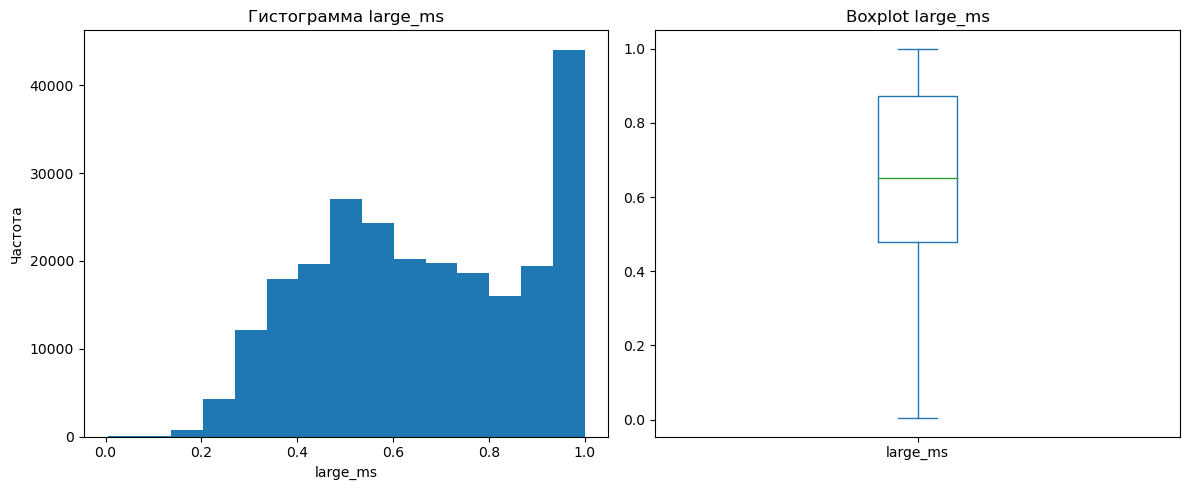

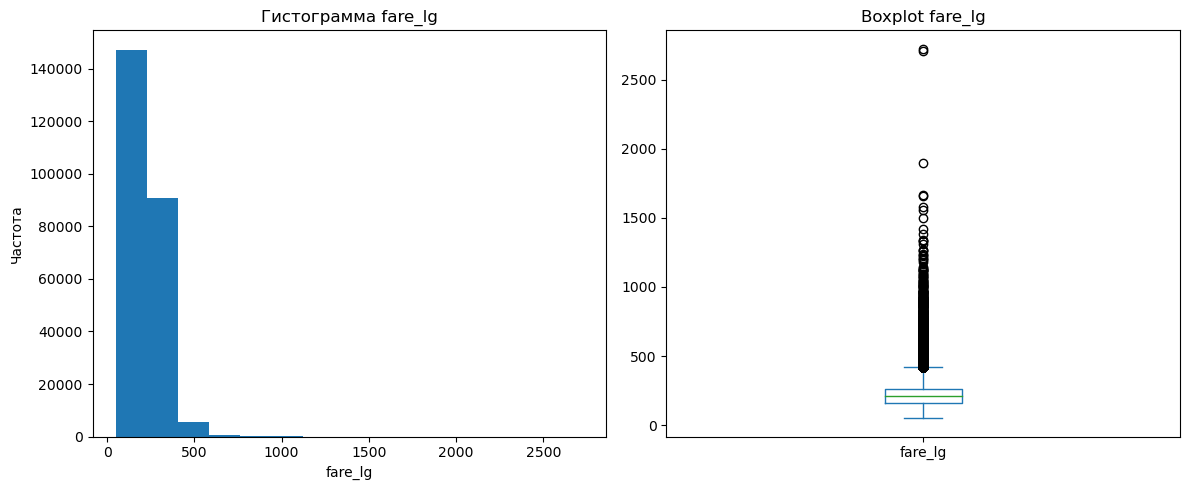

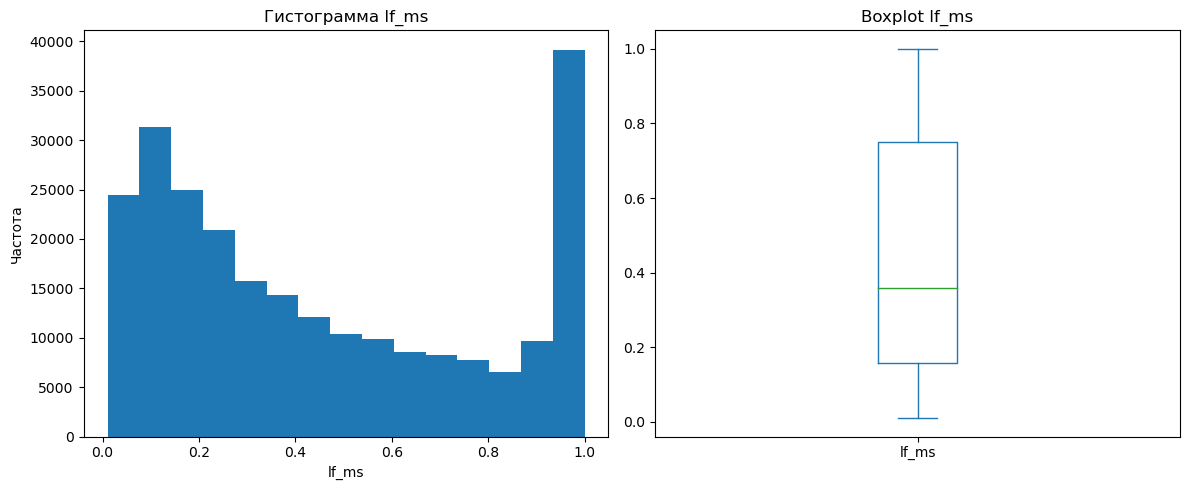

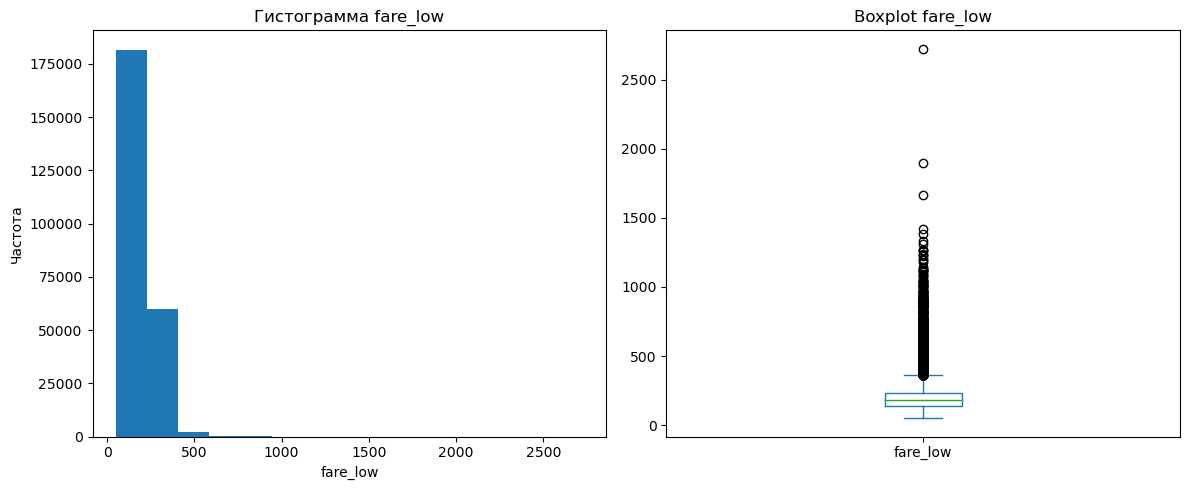

In [101]:
def num_hist(df, lst):
    for i in lst:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
        
        df[i].plot(kind='hist', bins=15, ax=axes[0])
        axes[0].set_title(f'Гистограмма {df[i].name}')
        axes[0].set_xlabel(df[i].name)
        axes[0].set_ylabel('Частота')

        df[i].plot(kind='box', ax=axes[1])
        axes[1].set_title(f'Boxplot {df[i].name}')
        
        plt.tight_layout()
        plt.show()
num_hist(data, ["Year", "quarter", "nsmiles", "passengers", "fare", "large_ms", "fare_lg", "lf_ms", "fare_low"])

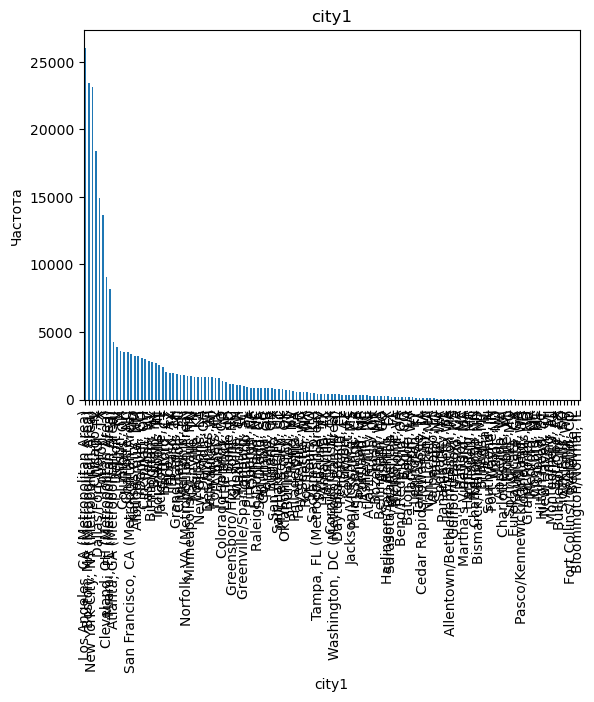

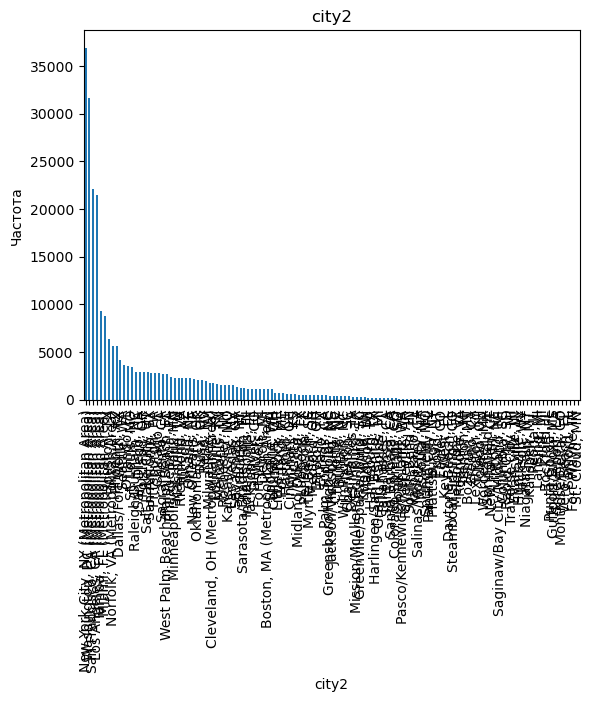

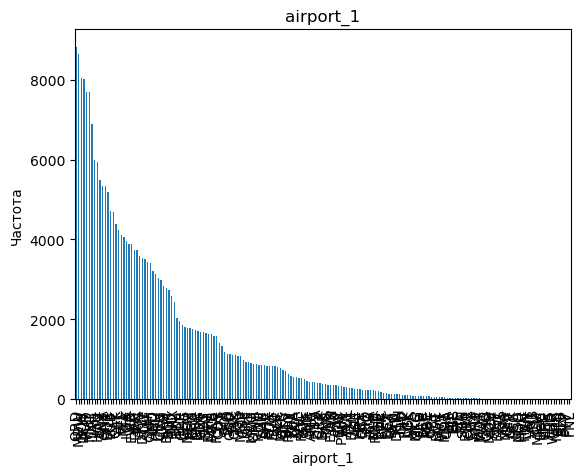

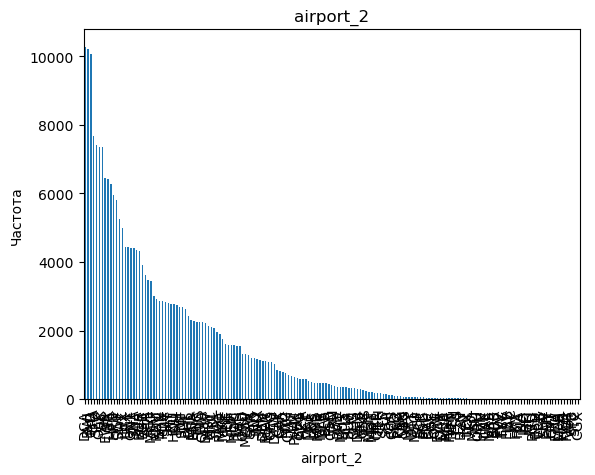

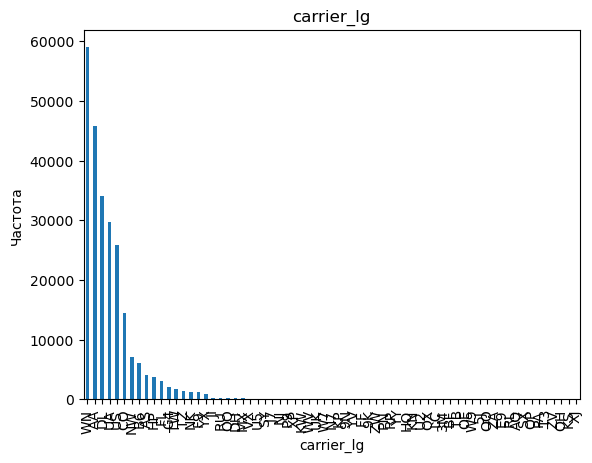

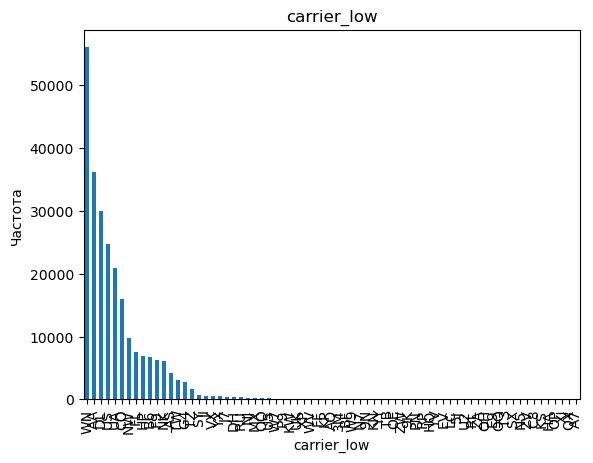

In [102]:
def cat_bar(df, lst, top_10_columns=None):
    
    top_10_columns = top_10_columns or []
    
    for col in lst:
        plt.figure()
        if col in top_10_columns:
            data = df[col].value_counts().head(10)
        else:
            data = df[col].value_counts()
        
        data.plot(kind='bar')
        plt.title(col)
        plt.xlabel(col)
        plt.ylabel('Частота')
        plt.show()
cat_bar(data, ["city1", "city2", "airport_1", "airport_2", "carrier_lg", "carrier_low"])

In [103]:
print(f'Процент записей, содержащих пропуски: {1612/len(data)*100}%')

Процент записей, содержащих пропуски: 0.6554044439023399%


In [104]:
data = data.dropna(subset = ['carrier_lg', 'large_ms', 'fare_lg', 'carrier_low', 'lf_ms', 'fare_low'])
data.isna().sum()

Year           0
quarter        0
city1          0
city2          0
airport_1      0
airport_2      0
nsmiles        0
passengers     0
fare           0
carrier_lg     0
large_ms       0
fare_lg        0
carrier_low    0
lf_ms          0
fare_low       0
dtype: int64

Теперь мы имеем 244343 записи без пропусков в данных, что позволит провести дальнейший анализ.

In [105]:
data = data[data["Year"] != 2024]

In [106]:
print(f'Количество строк после удаления: {len(data)}')

Количество строк после удаления: 242444


Выведем описательную статистику:

In [107]:
data.describe()

,Year,quarter,nsmiles,passengers,fare,large_ms,fare_lg,lf_ms,fare_low
count,242444.000000,242444.000000,242444.000000,242444.000000,242444.000000,242444.000000,242444.000000,242444.000000,242444.000000
mean,2008.456708,2.490678,1189.418604,300.737073,218.141290,0.665066,218.407622,0.449987,190.495074
std,8.614392,1.118776,703.056314,511.751275,79.423041,0.224434,84.516591,0.332544,73.486377
min,1993.000000,1.000000,109.000000,0.000000,50.000000,0.100000,50.000000,0.010000,50.000000
25%,2001.000000,1.000000,626.000000,22.000000,164.440000,0.480000,161.250000,0.157075,139.980000
50%,2008.000000,2.000000,1021.000000,114.000000,208.970000,0.651600,207.680000,0.360000,181.420000
75%,2016.000000,3.000000,1735.000000,341.000000,262.282500,0.870000,263.292500,0.750000,229.800000
max,2023.000000,4.000000,2724.000000,8301.000000,3377.000000,1.000000,2725.600000,1.000000,2725.600000


### Анализ пассажиропотока

Рассчитываем общее количество пассажиров за каждый год. Визуализируем результат, чтобы отследить тенденцию.

In [108]:
passengers_by_year = data.groupby('Year')['passengers'].sum().reset_index()
passengers_by_year

,Year,passengers
0,1993,1538123
1,1994,397639
2,1996,2001616
3,1997,2141358
4,1998,2176741
5,1999,2322840
6,2000,2451166
7,2001,2227580
8,2002,2163044
9,2003,2195068


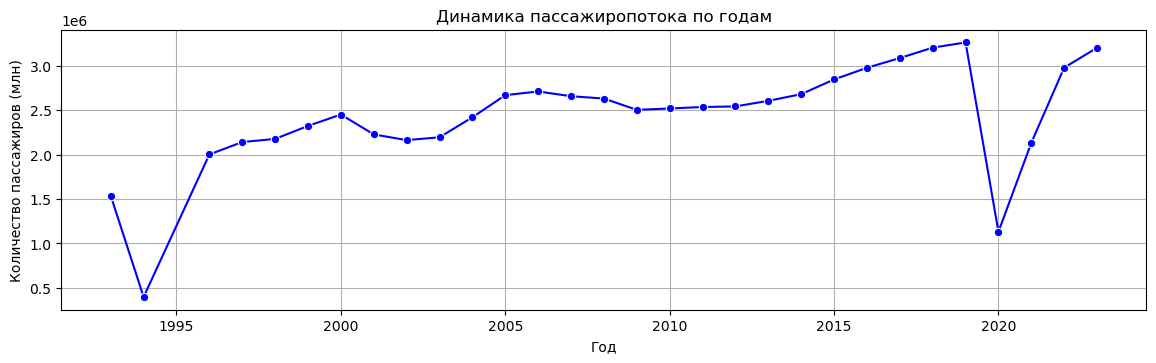

In [109]:
plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
sns.lineplot(data=passengers_by_year, x='Year', y='passengers', marker='o', color='blue')
plt.title("Динамика пассажиропотока по годам")
plt.xlabel("Год")
plt.ylabel("Количество пассажиров (млн)")
plt.grid()

На данном графике мы видим:
1. Резкий спад в 1994-1995 годах. Это связано с недостаточной полнотой данных за 1994 год (аномально маленькое число записей за 1994 год по сравнению с другими и отсутствие данных за 1995 год в принципе).
2. Увеличение пассажиропотока с 1995 по 2000 год. Это может быть связано с ростом доступности авиаперелетов, развитием авиакомпаний и увеличением спроса на авиапутешествия.
3. Небольшой спад, начиная с 2001 года. Это может быть связано с некоторыми политическими событиями в США того времени.
4. Далее пассажиропоток увеличивается и превосходит предыдущий пик в 2000 году.
5. Стагнация и спад в 2008-2010 годах. Вероятно, причиной является мировой финансовый кризис 2008 года, который сильно ударил по доходам населения и сократил количество путешествий.
6. Устойчивый рост с 2010 по 2019 год. Уверенный рост пассажиропотока в этот период может быть связан с экономическим восстановлением, расширением бюджетных авиакомпаний и увеличением числа международных перелетов.
7. Резкий спад в 2020 году. Этот спад, скорее всего, вызван пандемией COVID-19, которая привела к отмене рейсов и резкому сокращению спроса на авиаперелеты.
8. Восстановление после 2020 года. Наблюдается частичное восстановление пассажиропотока, хотя уровень до пандемии пока не достигнут. Это отражает постепенное восстановление авиакомпаний и рост спроса на путешествия.
9. В 2024 году наблюдается спад на графике. Это может быть связано с недостаточной актуальностью данных, поскольку год еще не закончился и количество пассажиров в 2024 году не может быть актутальным на данный момент.

Проследим зависимость пассажиропотока от сезона:

In [110]:
passengers_by_quarter = data.groupby('quarter')['passengers'].sum().reset_index()
passengers_by_quarter

,quarter,passengers
0,1,17034842
1,2,18989251
2,3,18376144
3,4,18511662


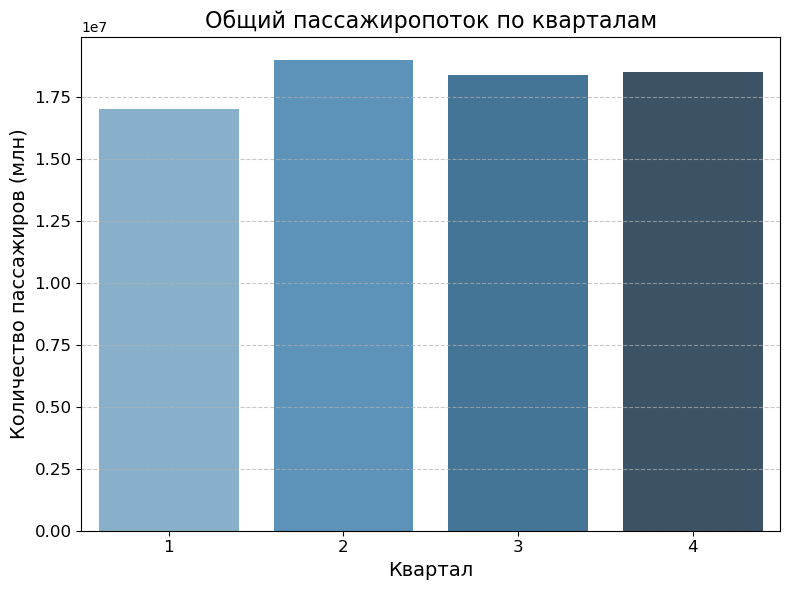

In [111]:
plt.figure(figsize=(8, 6))
sns.barplot(data=passengers_by_quarter, x='quarter', y='passengers', palette='Blues_d')

plt.title("Общий пассажиропоток по кварталам", fontsize=16)
plt.xlabel("Квартал", fontsize=14)
plt.ylabel("Количество пассажиров (млн)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Как мы можем наблюдать, фактор сезонности никак не влияет на объем пассажиропотока. В каждый из сезонов количество пассажиров, пользующихся авиаперелетами, примерно одинаковое.

### Анализ тарифов 

Для начала изучим как изменялись средние тарифы по годам и кварталам.

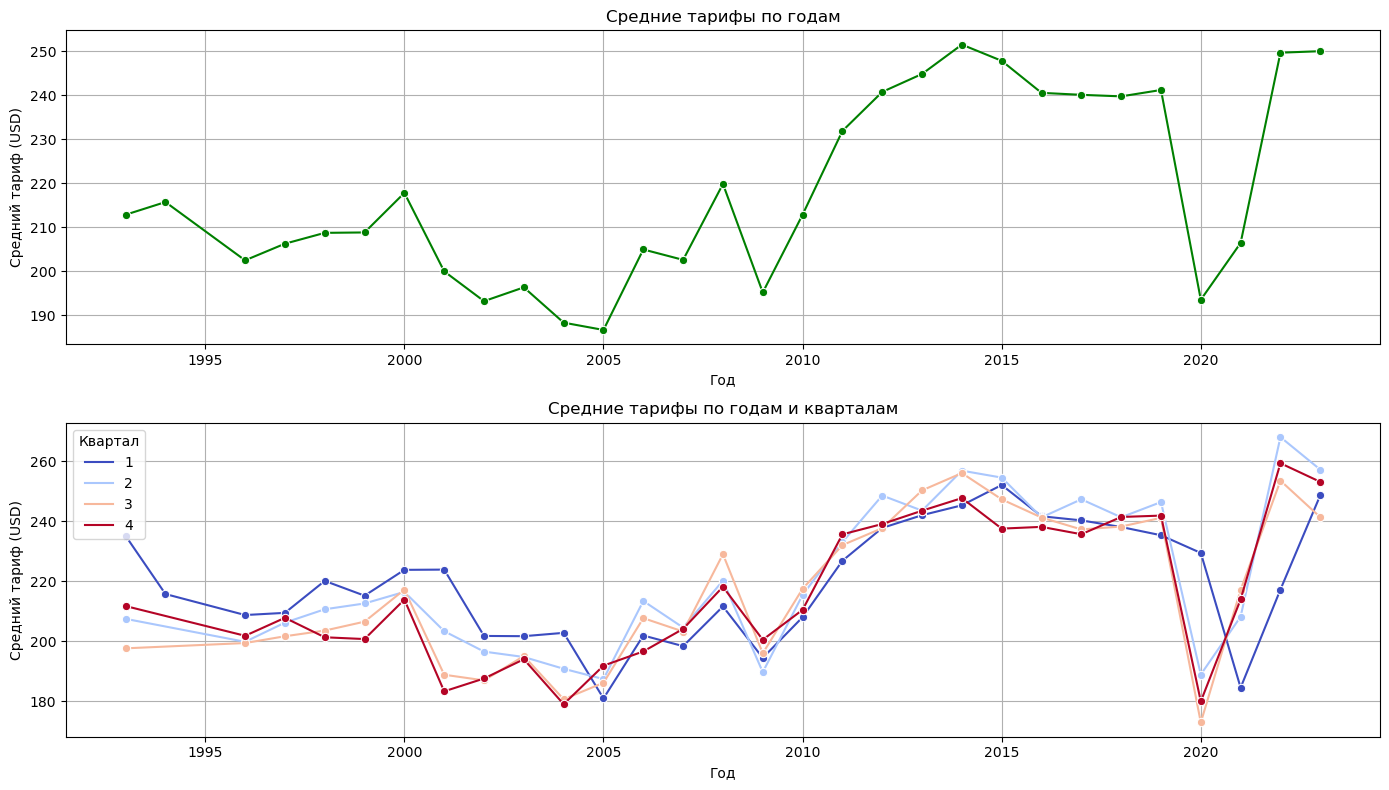

In [112]:
# Средние тарифы по годам
average_fare_by_year = data.groupby('Year')['fare'].mean().reset_index()

# Средние тарифы по годам и кварталам
average_fare_by_quarter = data.groupby(['Year', 'quarter'])['fare'].mean().reset_index()

# Визуализация
plt.figure(figsize=(14, 8))

# График среднего тарифа по годам
plt.subplot(2, 1, 1)
sns.lineplot(data=average_fare_by_year, x='Year', y='fare', marker='o', color='green')
plt.title("Средние тарифы по годам")
plt.xlabel("Год")
plt.ylabel("Средний тариф (USD)")
plt.grid()

# График среднего тарифа по годам и кварталам
plt.subplot(2, 1, 2)
sns.lineplot(data=average_fare_by_quarter, x='Year', y='fare', hue='quarter', marker='o', palette='coolwarm')
plt.title("Средние тарифы по годам и кварталам")
plt.xlabel("Год")
plt.ylabel("Средний тариф (USD)")
plt.legend(title="Квартал", loc='upper left')
plt.grid()

plt.tight_layout()
plt.show()

Если говорить про динами изменения тарифов по кварталам, то тот или иной квартал не весомо влияет на цены. Можно лишь подметить, что первый квартал "дороже" остальных. Это может быть связано с наступлением нового года и, соответственно, ростом цен на этот период.

Если смотреть на график динамики изменения тарифов по годам, то можно предположить, что существует некая корреляция с пассажиропотоками. В периоды экономических кризисов, политических факторов и пандемии тарифы падают, в "спокойное время" повышаются.

Вычислим корреляцию между пассажиропотоком и тарифом по годам. Будем использовать коэффициент корреляции Пирсона:

Коэффициент корреляции Спирмена для тарифа 0-500: 0.60


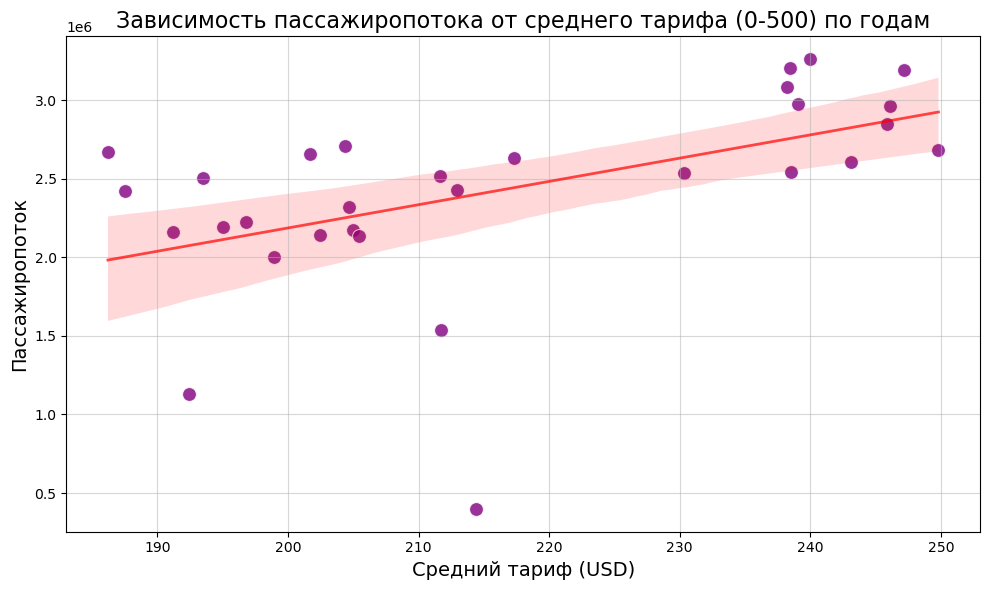

Коэффициент корреляции Спирмена для тарифа 501-1000: -0.31


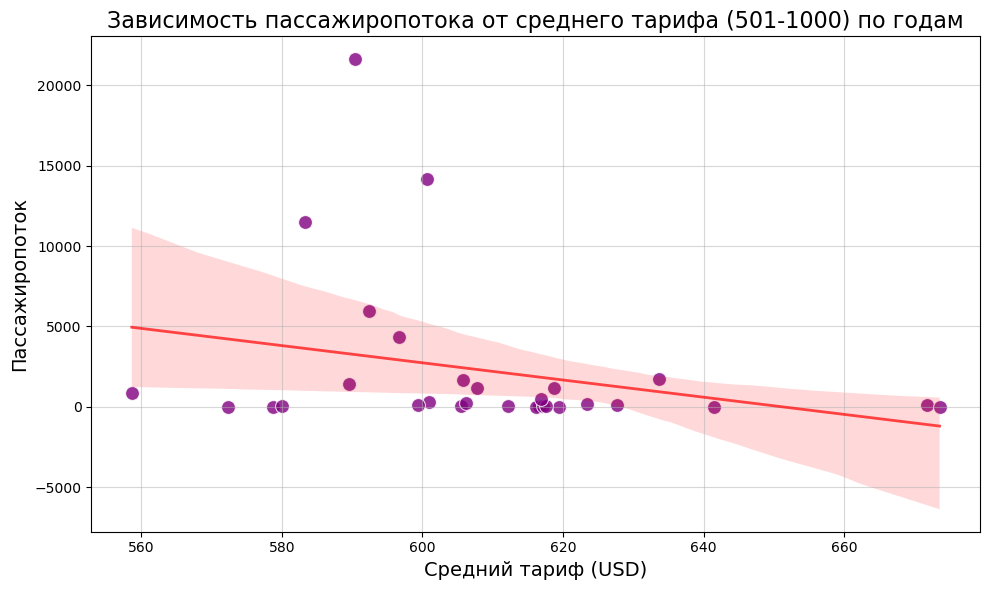

Коэффициент корреляции Спирмена для тарифа 1001-1500: 0.33


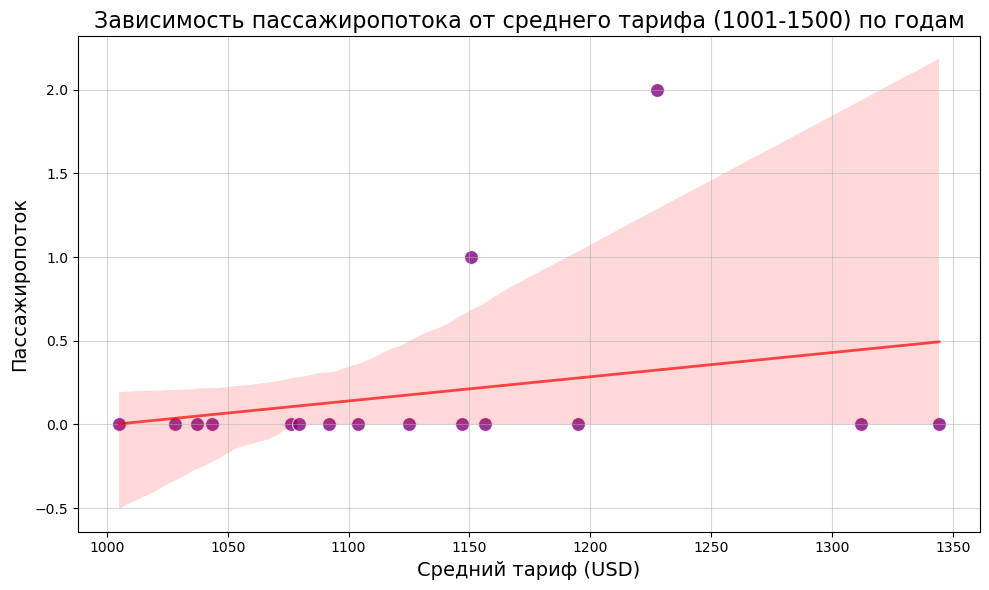

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Определяем диапазоны тарифов
bins = [0, 500, 1000, 1500]
labels = ['0-500', '501-1000', '1001-1500']

# Категоризируем тарифы по диапазонам
data['fare_range'] = pd.cut(data['fare'], bins=bins, labels=labels, right=False)

# Группируем данные по году и диапазону тарифов
yearly_data = data.groupby(['Year', 'fare_range']).agg(
    total_passengers=('passengers', 'sum'),
    avg_fare=('fare', 'mean')
).reset_index()

# Проходимся по каждому диапазону тарифов и считаем корреляцию и рисуем график
for fare_range in labels:
    subset = yearly_data[yearly_data['fare_range'] == fare_range]
    if len(subset) > 1 : # Проверяем, что есть данные в этом диапазоне
        # Вычисление корреляции Спирмена
        correlation = subset['total_passengers'].corr(subset['avg_fare'], method='spearman')
        print(f"Коэффициент корреляции Спирмена для тарифа {fare_range}: {correlation:.2f}")


        # Визуализация данных
        plt.figure(figsize=(10, 6))
        sns.scatterplot(
            data=subset,
            x='avg_fare',
            y='total_passengers',
            color='purple',
            s=100,
            alpha=0.8
        )

        # Линия регрессии
        sns.regplot(
            data=subset,
            x='avg_fare',
            y='total_passengers',
            scatter=False,
            color='red',
            line_kws={'linewidth': 2, 'alpha': 0.7}
        )

        # Оформление графика
        plt.title(f"Зависимость пассажиропотока от среднего тарифа ({fare_range}) по годам", fontsize=16)
        plt.xlabel("Средний тариф (USD)", fontsize=14)
        plt.ylabel("Пассажиропоток", fontsize=14)
        plt.grid(alpha=0.5)
        plt.tight_layout()
        plt.show()

    else:
       print(f"Нет данных для диапазона тарифа {fare_range}")


1. Положительная корреляция (например, 0.60): Означает, что с увеличением среднего тарифа в данном диапазоне, общее количество пассажиров также имеет тенденцию увеличиваться. Это говорит о том, что в этом диапазоне более высокие тарифы могут быть ассоциированы с более высоким спросом.

2. Отрицательная корреляция (например, -0.31): Означает, что с увеличением среднего тарифа в данном диапазоне, общее количество пассажиров имеет тенденцию уменьшаться. Это говорит о том, что в этом диапазоне более высокие тарифы могут отпугивать пассажиров, приводя к снижению спроса.

3. Слабая положительная корреляция (например, 0.33): Означает, что с увеличением среднего тарифа в данном диапазоне, общее количество пассажиров имеет тенденцию незначительно увеличиваться. Такая слабая корреляция может говорить о том, что в данном диапазоне есть другие факторы, которые больше влияют на количество пассажиров, чем цена.

Выясним какие маршруты имеют самые высокие и самые низкие тарифы.
Выведем топ-10 из одной и другой группы.

In [114]:
# Группировка данных по маршрутам и расчет среднего тарифа
average_fare_by_route = data.groupby(['city1', 'city2'])['fare'].mean().reset_index()

# Топ-10 маршрутов с самыми высокими тарифами
top_expensive_routes = (
    average_fare_by_route
    .sort_values(by='fare', ascending=False)
    .head(10)
    .rename(columns={'city1': 'Origin City', 'city2': 'Destination City', 'fare': 'Average Fare (USD)'})
)

# Топ-10 маршрутов с самыми низкими тарифами
top_cheap_routes = (
    average_fare_by_route
    .sort_values(by='fare', ascending=True)
    .head(10)
    .rename(columns={'city1': 'Origin City', 'city2': 'Destination City', 'fare': 'Average Fare (USD)'})
)

# Вывод в виде красивых таблиц pandas
print("Топ-10 маршрутов с самыми высокими тарифами:")
display(top_expensive_routes)

print("Топ-10 маршрутов с самыми низкими тарифам:")
display(top_cheap_routes)


Топ-10 маршрутов с самыми высокими тарифами:


,Origin City,Destination City,Average Fare (USD)
792,"Jackson, WY","New York City, NY (Metropolitan Area)",422.630242
620,"Eagle, CO","Miami, FL (Metropolitan Area)",420.244643
45,"Aspen, CO","New York City, NY (Metropolitan Area)",419.926613
44,"Aspen, CO","Miami, FL (Metropolitan Area)",398.735000
626,"El Paso, TX","Miami, FL (Metropolitan Area)",391.130000
775,"Huntsville, AL","Los Angeles, CA (Metropolitan Area)",372.231333
206,"Bozeman, MT","New York City, NY (Metropolitan Area)",363.247458
621,"Eagle, CO","New York City, NY (Metropolitan Area)",358.086781
1070,"New York City, NY (Metropolitan Area)","Palm Springs, CA",354.532138
712,"Hartford, CT","Minneapolis/St. Paul, MN",345.910000


Топ-10 маршрутов с самыми низкими тарифам:


,Origin City,Destination City,Average Fare (USD)
224,"Bullhead City, AZ","San Francisco, CA (Metropolitan Area)",63.405000
71,"Atlantic City, NJ","Detroit, MI",71.924286
102,"Belleville, IL","Tampa, FL (Metropolitan Area)",72.150000
1238,"Seattle, WA","Spokane, WA",72.450000
1199,"Reno, NV","Seattle, WA",73.480000
833,"Kansas City, MO","Tulsa, OK",73.937500
283,"Chicago, IL","Flint, MI",76.805000
805,"Jacksonville, FL","Tampa, FL (Metropolitan Area)",79.585000
831,"Kansas City, MO","St. Louis, MO",80.085676
1208,"Sacramento, CA","San Diego, CA",80.376400


Данные результаты не позволяют сделать какие-либо выводы. Попробуем добавить какой-нибудь признак, например, расстояние между городами (nsmiles):

In [115]:
# Группировка данных по маршрутам и расчет среднего тарифа
average_fare_by_route = data.groupby(['city1', 'city2', 'nsmiles'])['fare'].mean().reset_index()

# Топ-10 маршрутов с самыми высокими тарифами
top_expensive_routes = (
    average_fare_by_route
    .sort_values(by='fare', ascending=False)
    .head(10)
    .rename(columns={'city1': 'Origin City', 'city2': 'Destination City', 'nsmiles': 'Расстояние', 'fare': 'Average Fare (USD)'})
)

# Топ-10 маршрутов с самыми низкими тарифами
top_cheap_routes = (
    average_fare_by_route
    .sort_values(by='fare', ascending=True)
    .head(10)
    .rename(columns={'city1': 'Origin City', 'city2': 'Destination City', 'nsmiles': 'Расстояние', 'fare': 'Average Fare (USD)'})
)

# Вывод в виде красивых таблиц pandas
print("Топ-10 маршрутов с самыми высокими тарифами:")
display(top_expensive_routes)

print("Топ-10 маршрутов с самыми низкими тарифам:")
display(top_cheap_routes)

Топ-10 маршрутов с самыми высокими тарифами:


,Origin City,Destination City,Расстояние,Average Fare (USD)
1011,"Hartford, CT","San Francisco, CA (Metropolitan Area)",2629,487.567500
1121,"Jackson, WY","New York City, NY (Metropolitan Area)",1925,452.113214
893,"Eagle, CO","Miami, FL (Metropolitan Area)",1810,446.302273
58,"Aspen, CO","New York City, NY (Metropolitan Area)",1750,445.754687
1120,"Jackson, WY","New York City, NY (Metropolitan Area)",1894,414.031042
895,"Eagle, CO","New York City, NY (Metropolitan Area)",1746,408.011714
896,"Eagle, CO","New York City, NY (Metropolitan Area)",1747,405.800000
57,"Aspen, CO","Miami, FL (Metropolitan Area)",1796,398.735000
904,"El Paso, TX","Miami, FL (Metropolitan Area)",1633,391.130000
1537,"New York City, NY (Metropolitan Area)","Tucson, AZ",2142,390.318333


Топ-10 маршрутов с самыми низкими тарифам:


,Origin City,Destination City,Расстояние,Average Fare (USD)
288,"Bullhead City, AZ","San Francisco, CA (Metropolitan Area)",467,63.405000
1402,"Miami, FL (Metropolitan Area)","Tampa, FL (Metropolitan Area)",210,66.437500
94,"Atlantic City, NJ","Detroit, MI",497,71.165833
143,"Belleville, IL","Tampa, FL (Metropolitan Area)",841,72.150000
1716,"Seattle, WA","Spokane, WA",224,72.450000
881,"Detroit, MI","St. Louis, MO",462,72.986667
1668,"Reno, NV","Seattle, WA",564,73.480000
1175,"Kansas City, MO","Tulsa, OK",223,73.937500
95,"Atlantic City, NJ","Detroit, MI",506,76.475000
370,"Chicago, IL","Flint, MI",223,76.805000


Теперь мы можем наблюдать группировку маршрутов с учетом среднего расстояния между пунктами. Можно предположить, что они определенным образом взаимосвязаны. Проверим зависимость среднего тарифа от расстояния между аэропортами:

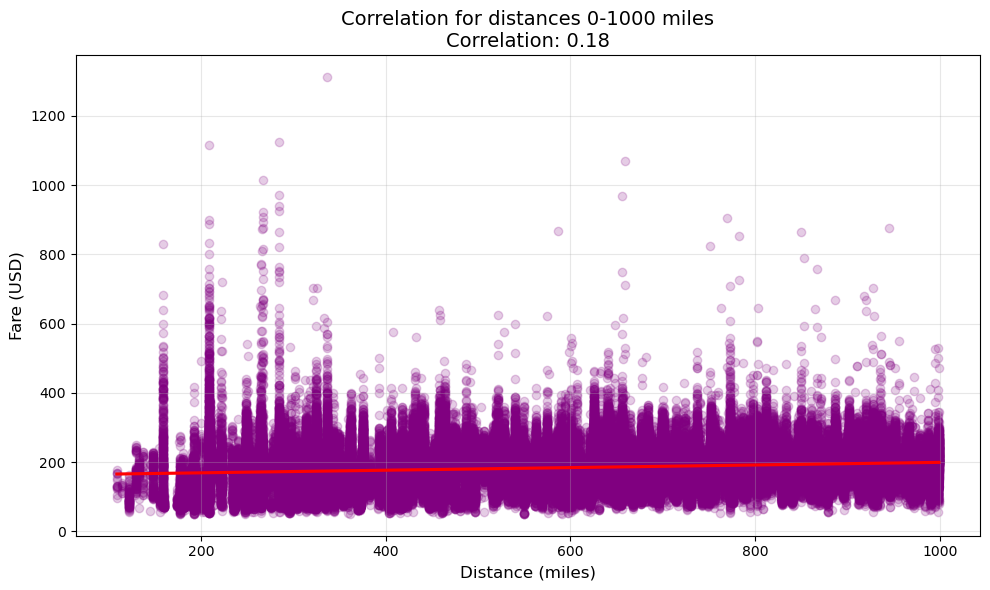

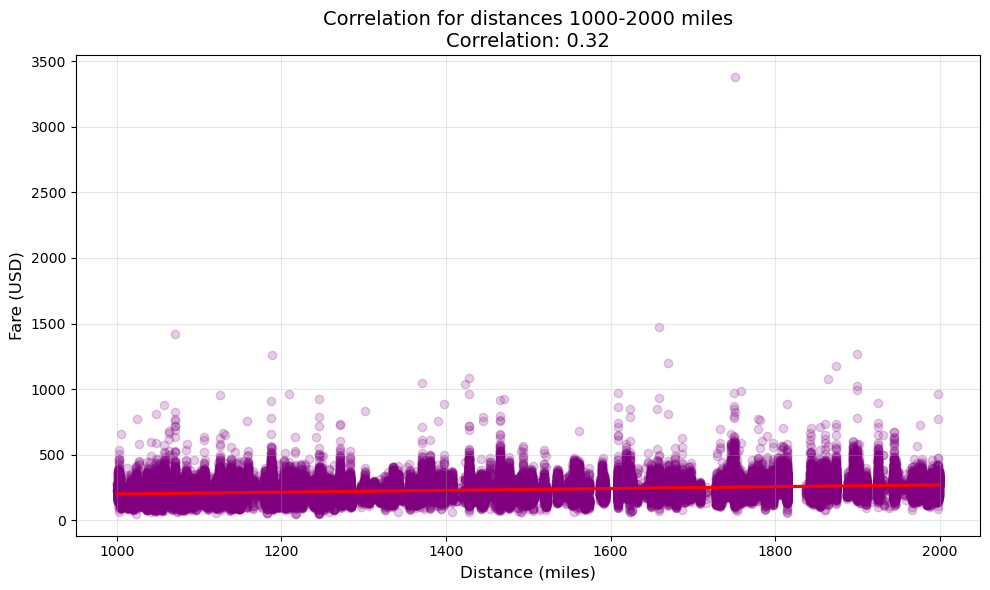

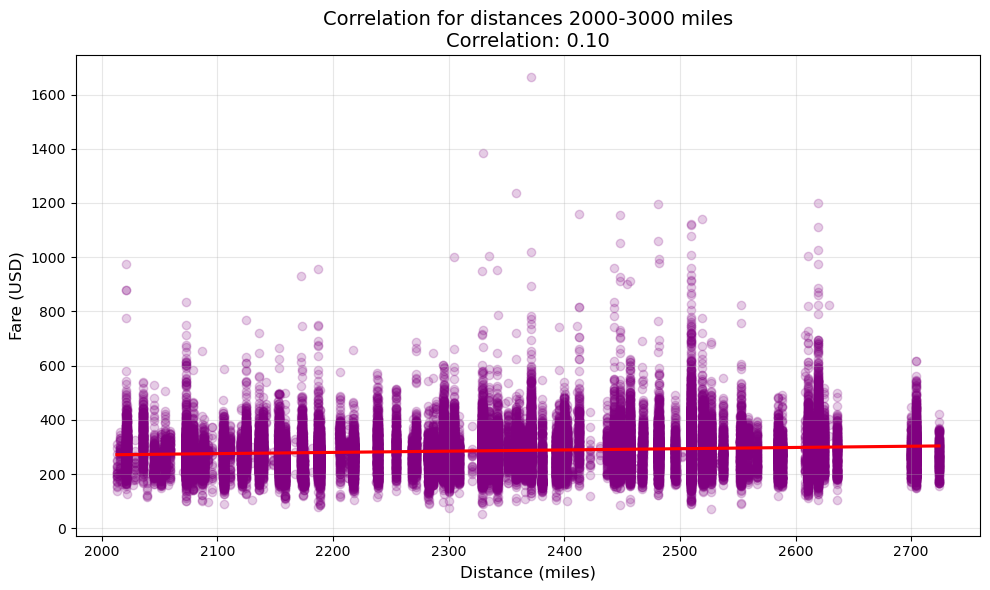

In [117]:
# Функция для расчета корреляции и построения графика
def plot_correlation(data, range_min, range_max, title):
    # Фильтруем данные
    filtered_data = data[(data['nsmiles'] >= range_min) & (data['nsmiles'] < range_max)]
    
    # Расчет корреляции
    if not filtered_data.empty:
        correlation, _ = spearmanr(filtered_data['nsmiles'], filtered_data['fare'])
    else:
        correlation = None
    
    # Визуализация
    plt.figure(figsize=(10, 6))
    sns.regplot(
        x='nsmiles', y='fare', data=filtered_data,
        scatter_kws={'alpha': 0.2, 'color': 'purple'},
        line_kws={'color': 'red'}
    )
    plt.title(f'{title}\nCorrelation: {correlation:.2f}' if correlation else f'{title}\nCorrelation: N/A', fontsize=14)
    plt.xlabel('Distance (miles)', fontsize=12)
    plt.ylabel('Fare (USD)', fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Построение графиков для трех диапазонов
plot_correlation(data, 0, 1000, 'Correlation for distances 0-1000 miles')
plot_correlation(data, 1000, 2000, 'Correlation for distances 1000-2000 miles')
plot_correlation(data, 2000, 3000, 'Correlation for distances 2000-3000 miles')

Выводы по результатам анализа:
Диапазон 0–1000 миль (корреляция: 0.18):

Для коротких расстояний зависимость между тарифом и расстоянием слабая. Это связано с тем, что тарифы на короткие рейсы часто включают фиксированные расходы, такие как топливные сборы, аэропортовые налоги и фиксированные затраты на обслуживание, которые оказывают большее влияние на итоговую цену.
Диапазон 1000–2000 миль (корреляция: 0.32):

В среднем диапазоне расстояний зависимость между тарифами и расстоянием более выражена. Это объясняется тем, что такие рейсы больше подвержены влиянию переменных затрат (например, расход топлива на более длинные маршруты), и тарифы начинают зависеть от расстояния в большей степени.
Диапазон 2000–3000 миль (корреляция: 0.10):

Для дальних расстояний зависимость становится менее выраженной. Это может быть связано с конкуренцией между авиакомпаниями, которые предлагают скидки на популярные дальние маршруты. Также можно предположить, что для дальних рейсов используются более крупные самолеты, которые снижают себестоимость перевозки пассажиров.

### Конкуренция Авиакомпаний

Посмотрим информацию о том, какие авиакомпании лидируют по рыночной доле на определенных маршрутах:

In [118]:
# Группировка данных по маршрутам и авиакомпаниям
market_share = data.groupby(['city1', 'city2', 'carrier_lg'])['passengers'].sum().reset_index()

# Определение авиакомпании с наибольшей долей на каждом маршруте
market_leader = market_share.loc[market_share.groupby(['city1', 'city2'])['passengers'].idxmax()]

# Переименуем для красоты
market_leader = market_leader.rename(
    columns={
        'city1': 'Origin City',
        'city2': 'Destination City',
        'carrier_lg': 'Leading Carrier',
        'passengers': 'Total Passengers'
    }
)

# Сортировка по убыванию числа пассажиров
market_leader = market_leader.sort_values(by='Total Passengers', ascending=False)

print("Лидеры по рыночной доле на маршрутах:")
display(market_leader.head(10))

Лидеры по рыночной доле на маршрутах:


,Origin City,Destination City,Leading Carrier,Total Passengers
4328,"Los Angeles, CA (Metropolitan Area)","San Francisco, CA (Metropolitan Area)",WN,1453537
4337,"Los Angeles, CA (Metropolitan Area)","Seattle, WA",AS,651703
219,"Atlanta, GA (Metropolitan Area)","New York City, NY (Metropolitan Area)",DL,626843
3944,"Las Vegas, NV","Los Angeles, CA (Metropolitan Area)",WN,595554
5819,"San Diego, CA","San Francisco, CA (Metropolitan Area)",WN,547318
4294,"Los Angeles, CA (Metropolitan Area)","Sacramento, CA",WN,530027
4238,"Los Angeles, CA (Metropolitan Area)","Phoenix, AZ",WN,487569
1462,"Chicago, IL","New York City, NY (Metropolitan Area)",AA,484857
248,"Atlanta, GA (Metropolitan Area)","Washington, DC (Metropolitan Area)",DL,445641
4567,"Miami, FL (Metropolitan Area)","New York City, NY (Metropolitan Area)",B6,438437


Видим, что авиакомпании имеют большой пассажиропоток, как правило, между крупнейшими городами (метрополиями).
Интересной будет информация, которая покажет нам в целом самых крупных перевозчиков.

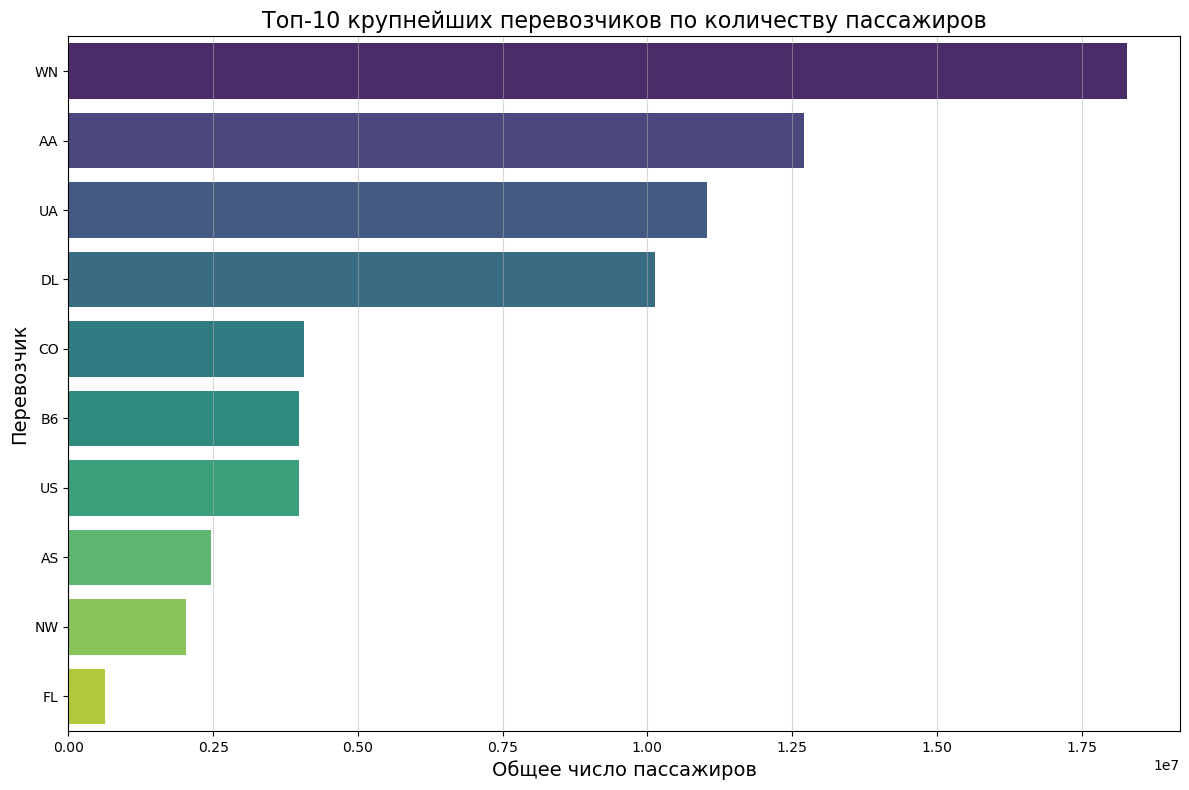

In [27]:
# Группировка данных по перевозчикам и расчет общего числа пассажиров
carrier_passenger_data = data.groupby('carrier_lg')['passengers'].sum().reset_index()

# Сортировка данных по убыванию числа пассажиров
carrier_passenger_data = carrier_passenger_data.sort_values(by='passengers', ascending=False)

# Выбор 10 самых крупных перевозчиков
top_10_carriers = carrier_passenger_data.head(10)

# Построение горизонтальной столбчатой диаграммы
plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_10_carriers,
    y='carrier_lg', x='passengers',
    palette='viridis'
)

# Оформление графика
plt.title('Топ-10 крупнейших перевозчиков по количеству пассажиров', fontsize=16)
plt.xlabel('Общее число пассажиров', fontsize=14)
plt.ylabel('Перевозчик', fontsize=14)
plt.grid(axis='x', alpha=0.5)
plt.tight_layout()
plt.show()


Далее посмотрим информацию о том, как соотносятся тарифы крупнейшего перевозчика и перевозчика с самым низким тарифом. 

In [28]:
# Найдем минимальные и максимальные тарифы на маршрутах
fare_comparison = data.groupby(['city1', 'city2']).agg(
    largest_fare=('fare_lg', 'mean'),  # Средний тариф крупнейшего перевозчика
    lowest_fare=('fare_low', 'mean')  # Средний тариф перевозчика с низким тарифом
).reset_index()

# Добавим разницу между тарифами
fare_comparison['fare_difference'] = fare_comparison['largest_fare'] - fare_comparison['lowest_fare']

# Переименуем столбцы для удобства
fare_comparison = fare_comparison.rename(
    columns={
        'city1': 'Origin City',
        'city2': 'Destination City',
        'largest_fare': 'Largest Fare (USD)',
        'lowest_fare': 'Lowest Fare (USD)',
        'fare_difference': 'Fare Difference (USD)'
    }
)

# Сортировка по убыванию разницы в тарифах
fare_comparison = fare_comparison.sort_values(by='Largest Fare (USD)', ascending=False)

# Вывод
print("Сравнение тарифов крупнейшего перевозчика и перевозчика с минимальным тарифом:")
display(fare_comparison.head(10))


Сравнение тарифов крупнейшего перевозчика и перевозчика с минимальным тарифом:


,Origin City,Destination City,Largest Fare (USD),Lowest Fare (USD),Fare Difference (USD)
792,"Jackson, WY","New York City, NY (Metropolitan Area)",424.092661,368.947984,55.144677
620,"Eagle, CO","Miami, FL (Metropolitan Area)",415.338214,379.300357,36.037857
45,"Aspen, CO","New York City, NY (Metropolitan Area)",414.977661,364.700484,50.277177
44,"Aspen, CO","Miami, FL (Metropolitan Area)",397.530000,384.220000,13.310000
626,"El Paso, TX","Miami, FL (Metropolitan Area)",387.115000,326.705000,60.410000
775,"Huntsville, AL","Los Angeles, CA (Metropolitan Area)",372.429333,336.614000,35.815333
206,"Bozeman, MT","New York City, NY (Metropolitan Area)",361.206441,300.398983,60.807458
621,"Eagle, CO","New York City, NY (Metropolitan Area)",358.232329,312.726027,45.506301
712,"Hartford, CT","Minneapolis/St. Paul, MN",355.145000,210.970000,144.175000
1070,"New York City, NY (Metropolitan Area)","Palm Springs, CA",346.174759,309.098103,37.076655


Есть предположение, что тариф крупнейшего перевозчика на направлении и самый низкий тариф на этом же направлении определенным образом связаны. Проверим, насколько они коррелируют, чтобы сделать соответствующие выводы.

Коэффициент корреляции между fare_lg и fare_low: 0.82


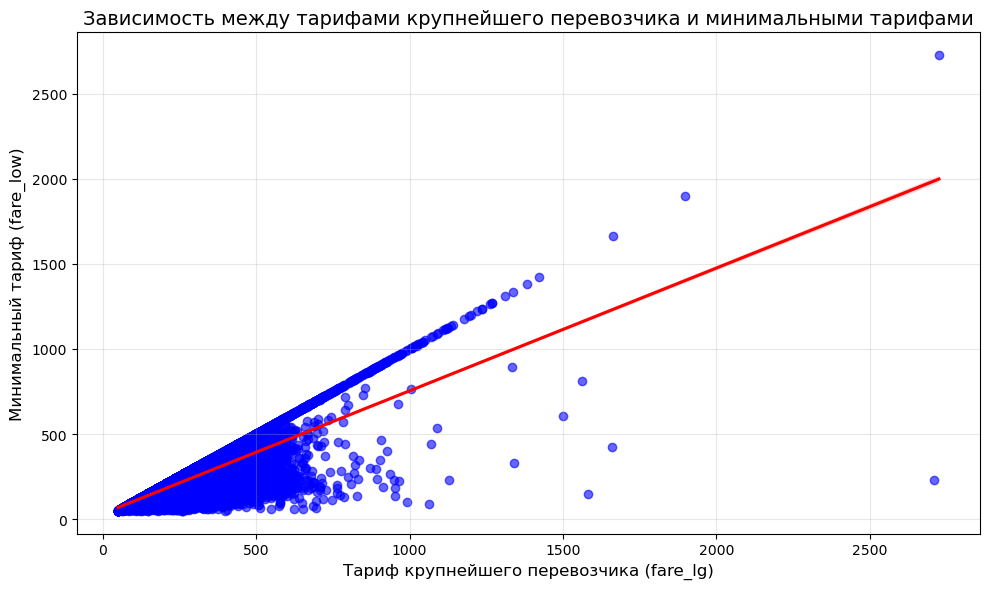

In [29]:
# Проверка наличия данных
if 'fare_lg' in data.columns and 'fare_low' in data.columns:
    # Расчет корреляции
    correlation, p_value = spearmanr(data['fare_lg'], data['fare_low'])
    print(f"Коэффициент корреляции между fare_lg и fare_low: {correlation:.2f}")
    
    # Построение графика
    plt.figure(figsize=(10, 6))
    sns.regplot(
        x='fare_lg', y='fare_low', data=data,
        scatter_kws={'alpha': 0.6, 'color': 'blue'},
        line_kws={'color': 'red'}
    )
    plt.title('Зависимость между тарифами крупнейшего перевозчика и минимальными тарифами', fontsize=14)
    plt.xlabel('Тариф крупнейшего перевозчика (fare_lg)', fontsize=12)
    plt.ylabel('Минимальный тариф (fare_low)', fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Данные не содержат столбцы 'fare_lg' и 'fare_low'.")


Судя по коэффициенту корреляции Пирсона, наблюдается очень высокая положительная зависимость. Это значит, что при росте тарифа крупнейшего перевозчика на направлении, самый низкий тариф так же растет.

Красная линия на графике обозначает линию тренда, подтверждая линейную природу зависимости. Однако часть точек заметно отклоняется от нее, что свидетельствует о влиянии дополнительных факторов на формирование минимальных тарифов. 

Тарифы крупнейшего перевозчика варьируются от 0 до 2500, тогда как минимальные тарифы колеблются в диапазоне от 0 до 2700, с большей концентрацией в области до 1000. Это может свидетельствовать о том, что рынок склонен к ценовой конкуренции, особенно в нижнем диапазоне, где минимальные тарифы заметно ниже тарифов лидера.

В нижней части графика наблюдается плотная концентрация точек, что, вероятно, указывает на активную конкуренцию со стороны других перевозчиков, предлагающих более низкие тарифы для привлечения клиентов. В то же время на графике видны отдельные аномальные значения: например, при высоких тарифах крупнейшего перевозчика (около 2500) минимальные тарифы остаются относительно низкими. Эти случаи могут быть обусловлены особенностями конкретных маршрутов или редкими рыночными ситуациями.

Таким образом, график демонстрирует, что крупнейший перевозчик играет роль ценового лидера, задавая общий уровень тарифов на рынке. Однако минимальные тарифы отличаются большей гибкостью, что позволяет конкурентам привлекать пассажиров за счет более низкой стоимости.

### Географический анализ

Посмотрим, какие маршруты являются наиболее популярными по пассажиропотоку:

In [30]:
import pandas as pd

# Ваш код для суммирования пассажиров по маршрутам
popular_routes = (
    data.groupby(['city1', 'city2'])['passengers']
    .sum()
    .reset_index()
    .sort_values(by='passengers', ascending=False)
)

# Топ-10 популярных маршрутов
top_popular_routes = popular_routes.head(10)

# Создание нового DataFrame со значениями переименованных колонок
renamed_routes = top_popular_routes.rename(columns={
    'city1': 'Origin City',
    'city2': 'Destination City',
    'passengers': 'Total Passengers'
})

# Вывод
print("Топ-10 самых популярных маршрутов по количеству пассажиров:")
display(renamed_routes)


Топ-10 самых популярных маршрутов по количеству пассажиров:


,Origin City,Destination City,Total Passengers
931,"Los Angeles, CA (Metropolitan Area)","San Francisco, CA (Metropolitan Area)",2130688
977,"Miami, FL (Metropolitan Area)","New York City, NY (Metropolitan Area)",1590325
910,"Los Angeles, CA (Metropolitan Area)","New York City, NY (Metropolitan Area)",1161592
1069,"New York City, NY (Metropolitan Area)","Orlando, FL",1022368
314,"Chicago, IL","New York City, NY (Metropolitan Area)",1011791
1086,"New York City, NY (Metropolitan Area)","San Francisco, CA (Metropolitan Area)",827220
201,"Boston, MA (Metropolitan Area)","Washington, DC (Metropolitan Area)",755044
60,"Atlanta, GA (Metropolitan Area)","New York City, NY (Metropolitan Area)",735547
934,"Los Angeles, CA (Metropolitan Area)","Seattle, WA",690026
846,"Las Vegas, NV","Los Angeles, CA (Metropolitan Area)",680646


По полученным данным, можно подтвердить, что самые популярные направления соединяют в основном крупнейшие города и метрополии.

### Эффективность перевозчиков

Посмотрим, какие авиакомпании предлагают наиболее конкурентные тарифы на длинных и коротких маршрутах. Для этого обусловимся, что короткими маршрутами назовем те, что составляют менее 1000 миль, остальные - длинными.

In [31]:
# Разделение маршрутов на короткие и длинные
short_routes = data[data['nsmiles'] < 1000]
long_routes = data[data['nsmiles'] >= 1000]

# Рассчитаем средний тариф по перевозчикам для коротких и длинных маршрутов
short_routes_fare = short_routes.groupby('carrier_low')['fare_low'].mean().reset_index()
long_routes_fare = long_routes.groupby('carrier_low')['fare_low'].mean().reset_index()

# Сортировка по минимальному тарифу для конкурентоспособных перевозчиков
short_routes_fare = short_routes_fare.sort_values(by='fare_low').reset_index(drop=True)
long_routes_fare = long_routes_fare.sort_values(by='fare_low').reset_index(drop=True)

# Вывод топ-10 перевозчиков с самыми низкими тарифами для коротких и длинных маршрутов
print("Топ-10 авиакомпаний с самыми низкими тарифами на коротких маршрутах:")
display(short_routes_fare.head(10))

print("Топ-10 авиакомпаний с самыми низкими тарифами на длинных маршрутах:")
display(long_routes_fare.head(10))


Топ-10 авиакомпаний с самыми низкими тарифами на коротких маршрутах:


,carrier_low,fare_low
0,A7,58.480000
1,HA,65.630000
2,C8,69.500000
3,KS,69.750000
4,KN,82.177692
5,N5,84.290000
6,N7,86.490000
7,AQ,86.903036
8,G4,88.967930
9,U2,91.077143


Топ-10 авиакомпаний с самыми низкими тарифами на длинных маршрутах:


,carrier_low,fare_low
0,P9,96.450000
1,OP,108.740000
2,PN,111.403333
3,G4,112.268885
4,E9,112.520000
5,XP,117.247273
6,WV,120.915000
7,J7,121.630000
8,RL,122.052500
9,KP,123.004615


Получили топ компаний с самыми низкими средними тарифами на длинных и коротких маршрутах. Возникает интерес посмотреть их долю рынка, чтобы подтвердить гипотезу о том, что их цены обеспечивают им большую долю рынка в авиаперевозках в США в принципе:

In [32]:
# Расчет пассажиропотока и долей рынка для коротких маршрутов
short_routes_stats = short_routes.groupby('carrier_low').agg(
    total_passengers=('passengers', 'sum'),
    average_fare=('fare_low', 'mean')
).reset_index()

# Добавление доли рынка
short_routes_stats['market_share'] = (
    short_routes_stats['total_passengers'] / short_routes['passengers'].sum()
)

# Сортировка по среднему тарифу
short_routes_stats = short_routes_stats.sort_values(by='average_fare').reset_index(drop=True)

# Расчет пассажиропотока и долей рынка для длинных маршрутов
long_routes_stats = long_routes.groupby('carrier_low').agg(
    total_passengers=('passengers', 'sum'),
    average_fare=('fare_low', 'mean')
).reset_index()

# Добавление доли рынка
long_routes_stats['market_share'] = (
    long_routes_stats['total_passengers'] / long_routes['passengers'].sum()
)

# Сортировка по среднему тарифу
long_routes_stats = long_routes_stats.sort_values(by='average_fare').reset_index(drop=True)

# Вывод таблиц
print("Топ-10 авиакомпаний с самыми низкими тарифами на коротких маршрутах (с пассажиропотоком и долей рынка):")
display(short_routes_stats.head(10))

print("Топ-10 авиакомпаний с самыми низкими тарифами на длинных маршрутах (с пассажиропотоком и долей рынка):")
display(long_routes_stats.head(10))


Топ-10 авиакомпаний с самыми низкими тарифами на коротких маршрутах (с пассажиропотоком и долей рынка):


,carrier_low,total_passengers,average_fare,market_share
0,A7,338,58.480000,0.000009
1,HA,712,65.630000,0.000018
2,C8,64,69.500000,0.000002
3,KS,0,69.750000,0.000000
4,KN,6247,82.177692,0.000157
5,N5,2023,84.290000,0.000051
6,N7,18313,86.490000,0.000461
7,AQ,64004,86.903036,0.001613
8,G4,217127,88.967930,0.005471
9,U2,498,91.077143,0.000013


Топ-10 авиакомпаний с самыми низкими тарифами на длинных маршрутах (с пассажиропотоком и долей рынка):


,carrier_low,total_passengers,average_fare,market_share
0,P9,132,96.450000,0.000004
1,OP,2643,108.740000,0.000080
2,PN,60,111.403333,0.000002
3,G4,169504,112.268885,0.005102
4,E9,35,112.520000,0.000001
5,XP,2745,117.247273,0.000083
6,WV,125,120.915000,0.000004
7,J7,14807,121.630000,0.000446
8,RL,1866,122.052500,0.000056
9,KP,31502,123.004615,0.000948


Как мы можем наблюдать, доля рынка у данных компаний незначительна. Это говорит о том, что тарифы этих компаний не дают им преимуществ на рынке. Скорее всего, они осуществляют перевозки на малопопулярных направлениях для ограниченного количества клиентов. Это может быть связано с гос. контрактами на данные перевозки.

Интересным также будет сравнение средней рыночной доли перевозчиков с самым низким тарифом и крупнейших операторов, чтобы посмотреть разницу в ценах:

In [33]:
# Группировка данных для вычисления рыночной доли
market_share_comparison = data.groupby(['city1', 'city2']).agg(
    largest_market_share=('large_ms', 'mean'),  # Средняя рыночная доля крупнейшего перевозчика
    lowest_market_share=('lf_ms', 'mean')  # Средняя рыночная доля перевозчика с самым низким тарифом
).reset_index()

# Переименование столбцов для удобства
market_share_comparison = market_share_comparison.rename(
    columns={
        'city1': 'Origin City',
        'city2': 'Destination City',
        'largest_market_share': 'Largest Carrier Market Share',
        'lowest_market_share': 'Lowest Carrier Market Share'
    }
)

# Сортировка по доле рынка крупнейшего перевозчика (по убыванию)
market_share_comparison = market_share_comparison.sort_values(by='Largest Carrier Market Share', ascending=False).reset_index(drop=True)

# Вывод результатов
print("Сравнение рыночных долей крупнейшего и перевозчика с минимальным тарифом:")
display(market_share_comparison.head(10))

Сравнение рыночных долей крупнейшего и перевозчика с минимальным тарифом:


,Origin City,Destination City,Largest Carrier Market Share,Lowest Carrier Market Share
0,"New Haven, CT","Tampa, FL (Metropolitan Area)",1.0,1.0
1,"Miami, FL (Metropolitan Area)","New Haven, CT",1.0,1.0
2,"Kansas City, MO","Tulsa, OK",1.0,1.0
3,"Phoenix, AZ","Rockford, IL",1.0,1.0
4,"Boston, MA (Metropolitan Area)","Punta Gorda, FL",1.0,1.0
5,"Ashland, WV","Tampa, FL (Metropolitan Area)",1.0,1.0
6,"Belleville, IL","Tampa, FL (Metropolitan Area)",1.0,1.0
7,"Columbus, OH","Punta Gorda, FL",1.0,1.0
8,"New York City, NY (Metropolitan Area)","Sanford, FL",1.0,1.0
9,"Latrobe, PA","Miami, FL (Metropolitan Area)",1.0,1.0


Для всех показанных маршрутов рыночная доля крупнейшего перевозчика (Largest Carrier Market Share) и перевозчика с минимальным тарифом (Lowest Carrier Market Share) равна 1.0.
Это означает, что на этих маршрутах фактически один и тот же перевозчик является как крупнейшим оператором, так и тем, кто предлагает самый низкий тариф. Кроме того, у него 100% рыночная доля на этих маршрутах.

Данная таблица демонстрирует монопольное положение авиакомпании. На этих направлениях, вероятно, нет других конкурентов, поэтому один перевозчик контролирует весь пассажиропоток.

Такая ситуация может говорить о том, что есть направления, перевозки на которых осуществляют определенные компания по разным причинам, например, государственные контракты.

Если на всех маршрутах наблюдается похожая картина, это может говорить о высокой сегментации рынка, где перевозчики распределили маршруты между собой, избегая прямой конкуренции.
Если же эта ситуация характерна только для небольшой части маршрутов, такие данные могут быть связаны с определенными характеристиками этих направлений (например, небольшие города или региональные маршруты).

### Проверка корреляционных зависимостей

Выведем таблицу коэффициентов корреляции, чтобы посмотреть наиболее связанные величины, выделим их:

In [34]:
correlation_matrix = data.select_dtypes(include='number').corr(method='spearman')

def highlight_cells(val):
    color = 'background-color: yellow' if val > 0.7 else ''
    return color

styled_correlation_matrix = correlation_matrix.style.applymap(highlight_cells)

styled_correlation_matrix

,Year,quarter,nsmiles,passengers,fare,large_ms,fare_lg,lf_ms,fare_low
Year,1.000000,0.023821,0.024523,0.096426,0.192867,0.101127,0.189180,0.106292,0.215215
quarter,0.023821,1.000000,-0.000133,0.025416,-0.016966,0.000803,-0.014080,0.000791,-0.007934
nsmiles,0.024523,-0.000133,1.000000,-0.103078,0.521333,-0.409705,0.492534,-0.236990,0.429088
passengers,0.096426,0.025416,-0.103078,1.000000,-0.269856,-0.082911,-0.218170,-0.207042,-0.299331
fare,0.192867,-0.016966,0.521333,-0.269856,1.000000,-0.216353,0.965432,-0.215483,0.863987
large_ms,0.101127,0.000803,-0.409705,-0.082911,-0.216353,1.000000,-0.205657,0.409167,-0.118003
fare_lg,0.189180,-0.014080,0.492534,-0.218170,0.965432,-0.205657,1.000000,-0.265791,0.822314
lf_ms,0.106292,0.000791,-0.236990,-0.207042,-0.215483,0.409167,-0.265791,1.000000,0.050189
fare_low,0.215215,-0.007934,0.429088,-0.299331,0.863987,-0.118003,0.822314,0.050189,1.000000


Видим, что очень высокую корреляцию имеют тариф крупнейшего перевозчика и минимальный тариф с общим тарифом.
Построим графики для визуализации

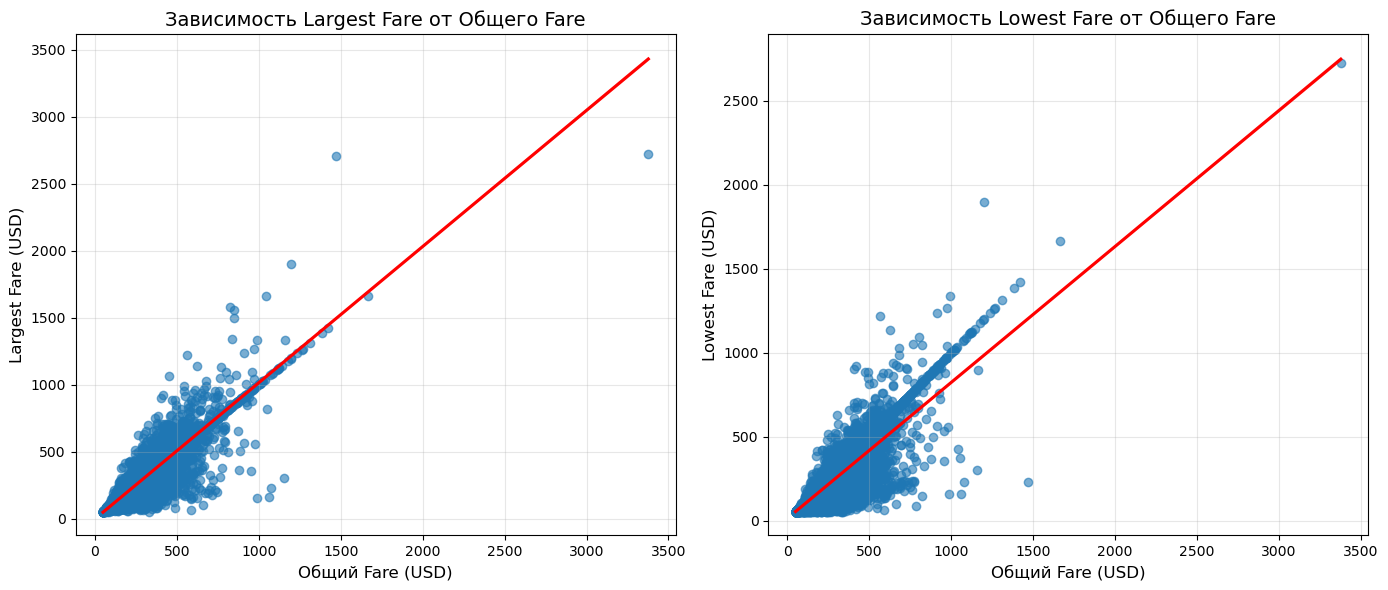

In [35]:
# Настройка размера графиков
plt.figure(figsize=(14, 6))

# График 1: Зависимость fare_lg от fare
plt.subplot(1, 2, 1)
sns.regplot(x='fare', y='fare_lg', data=data, scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'})
plt.title('Зависимость Largest Fare от Общего Fare', fontsize=14)
plt.xlabel('Общий Fare (USD)', fontsize=12)
plt.ylabel('Largest Fare (USD)', fontsize=12)
plt.grid(alpha=0.3)

# График 2: Зависимость fare_low от fare
plt.subplot(1, 2, 2)
sns.regplot(x='fare', y='fare_low', data=data, scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'})
plt.title('Зависимость Lowest Fare от Общего Fare', fontsize=14)
plt.xlabel('Общий Fare (USD)', fontsize=12)
plt.ylabel('Lowest Fare (USD)', fontsize=12)
plt.grid(alpha=0.3)

# Показываем графики
plt.tight_layout()
plt.show()


#### Левый график: Зависимость fare_lg (тариф крупнейшего перевозчика) от fare (общего среднего тарифа)

Высокая корреляция (0.96):
Большинство точек находятся близко к линии регрессии (красной прямой), что подтверждает сильную линейную зависимость.
Это означает, что тариф крупнейшего перевозчика практически пропорционален общему тарифу на маршруте.
Таким образом, крупнейшие перевозчики, как правило, определяют среднюю цену на рынке.

Небольшой разброс виден только для тарифов с меньшими значениями (до 500 USD), что может быть связано с влиянием конкуренции или скидочных предложений.
При больших значениях тарифа (выше 1000 USD) зависимость становится почти линейной.

#### Правый график: Зависимость fare_low (минимального тарифа) от fare (общего среднего тарифа)

Корреляция немного ниже (0.87):
Точки более разбросаны вокруг линии регрессии, особенно в диапазоне низких тарифов (до 500 USD).
Это свидетельствует о том, что минимальный тариф также связан с общим тарифом, но его влияние менее выражено по сравнению с крупнейшим перевозчиком.

Более широкий разброс для низких значений показывает, что минимальные тарифы зависят от политики отдельных авиакомпаний и уровня ценовой конкуренции.

Также, до этого мы анализировали долю рынка перевозчиков с самым низким тарифом и крупнейших операторов, пришли к выводу о том, что фактически это одни и те же компании.

Однако по таблице коэффициентов корреляции, видно что они все таки разнятся (значение коэффициента 0.53).
посмотрим на график корреляции:

Коэффициент корреляции между large_ms и lf_ms: 0.41


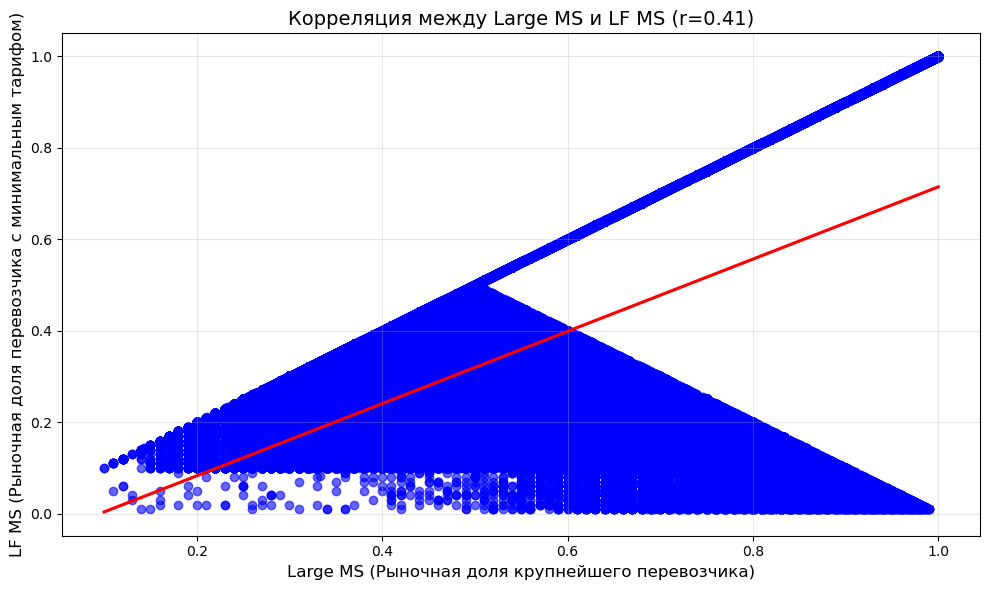

In [36]:
# Убедимся, что данные содержат необходимые столбцы
if 'large_ms' in data.columns and 'lf_ms' in data.columns:
    # Расчет корреляции
    correlation, _ = spearmanr(data['large_ms'], data['lf_ms'])
    print(f"Коэффициент корреляции между large_ms и lf_ms: {correlation:.2f}")

    # Построение графика
    plt.figure(figsize=(10, 6))
    sns.regplot(
        x='large_ms', y='lf_ms', data=data,
        scatter_kws={'alpha': 0.6, 'color': 'blue'},
        line_kws={'color': 'red'}
    )
    plt.title(f"Корреляция между Large MS и LF MS (r={correlation:.2f})", fontsize=14)
    plt.xlabel("Large MS (Рыночная доля крупнейшего перевозчика)", fontsize=12)
    plt.ylabel("LF MS (Рыночная доля перевозчика с минимальным тарифом)", fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Данные не содержат необходимые столбцы 'large_ms' и 'lf_ms'.")

График отражает связь между двумя показателями — Large MS и LF MS, и наглядно демонстрирует их умеренную положительную корреляцию (\( r = 0.53 \)). Это значит, что рост одного из показателей, как правило, сопровождается ростом второго, однако эта связь не является строго линейной и остается достаточно вариативной.

Большинство данных сконцентрировано в нижнем левом углу графика, что свидетельствует о преобладании случаев с небольшими долями показателей. Это может указывать на то, что у большинства перевозчиков как Large MS, так и LF MS находятся на низком уровне. В то же время на графике видны редкие случаи с высокими значениями обоих показателей, которые формируют треугольный верхний контур. Такое распределение может свидетельствовать о существовании определённого ограничения роста одного показателя относительно другого, вероятно, обусловленного особенностями рынка или поведением перевозчиков.

Красная линия регрессии отражает общий тренд, показывая положительную связь между переменными. Однако разброс данных относительно этой линии особенно заметен в правой части графика, где находятся более высокие значения Large MS и LF MS. Это может говорить о том, что на высоких уровнях значений связь между показателями становится менее предсказуемой. Вероятно, на это влияют дополнительные факторы, которые не отражены в данном графике.

Образование треугольного контура также может быть связано с влиянием внешних ограничений, таких как рыночные условия, ценовые стратегии или другие особенности, характерные для конкретного сегмента перевозчиков. Разброс точек в нижней части графика указывает на то, что в некоторых случаях LF MS остаётся низким даже при умеренном росте Large MS. Это может быть следствием различий в стратегиях перевозчиков, уровне конкуренции или даже методах расчёта показателей.

Для более детального анализа следует обратить внимание на участки с высокой плотностью данных в нижней части графика, так как они могут отражать типичное поведение перевозчиков. Также стоит отдельно изучить выбросы в верхней части, так как они могут быть результатом либо аномального поведения отдельных компаний, либо особенностей определённых рыночных условий. 

## Обучение модели

### Модель регрессии
Модель будет обучена для предсказания цены билета (fare)

In [119]:
model_cols = ['Year', 'quarter', 'airport_1', 'airport_2', 'large_ms', 'lf_ms', 'nsmiles']

In [120]:
X = data[model_cols]
y = data['fare']

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [122]:
from catboost import CatBoostRegressor

In [123]:
from catboost import CatBoostRegressor
categorical_features = ['Year', 'quarter', 'airport_1', 'airport_2']
model = CatBoostRegressor(
    iterations=800,
    learning_rate=0.1,
    depth=10,
    verbose=100
)

In [124]:
model.fit(X_train, y_train, cat_features=categorical_features)

0:	learn: 76.3039523	total: 181ms	remaining: 2m 24s
100:	learn: 45.2863927	total: 14.2s	remaining: 1m 38s
200:	learn: 42.1966938	total: 28.6s	remaining: 1m 25s
300:	learn: 40.2757587	total: 42.6s	remaining: 1m 10s
400:	learn: 38.7462429	total: 57.5s	remaining: 57.2s
500:	learn: 37.4185213	total: 1m 11s	remaining: 42.9s
600:	learn: 36.1422751	total: 1m 26s	remaining: 28.7s
700:	learn: 35.1020266	total: 1m 41s	remaining: 14.3s
799:	learn: 34.2458674	total: 1m 55s	remaining: 0us


In [125]:
y_pred = model.predict(X_test)

In [126]:
r2_score(y_test, y_pred)

0.747949340494955

In [133]:
np.sqrt(mean_squared_error(y_test, y_pred))

39.517008628483545

In [132]:
mean_absolute_error(y_test, y_pred)

24.27823188477741

In [135]:
mean_absolute_percentage_error(y_test, y_pred)

0.11573355019010219

Метрика r2 выдает значение 0.73

### Модель классификации
Будет осуществляться разделение на дорогие и дешевые билеты

Создадим целевой признак путем разбиения по квантилям, определяющий дешевый билет или дорогой.

In [46]:
data['fare_category'] = pd.qcut(data['fare'], q=2, labels=[0, 1])  # 0 - дешёвый, 1 - дорогой

In [47]:
model_cols = ['Year', 'quarter', 'airport_1', 'airport_2', 'large_ms', 'lf_ms', 'nsmiles', 'fare']

In [48]:
X = data[model_cols]
y = data['fare_category']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Также используем модель градиентного бустинга из catboost

In [50]:
from catboost import CatBoostClassifier, Pool
categorical_features = ['Year', 'quarter', 'airport_1', 'airport_2']
model_cl = CatBoostClassifier(
    iterations=800,
    learning_rate=0.1,
    depth=10,
    verbose=100
)

In [51]:
model_cl.fit(X_train, y_train, cat_features=categorical_features)

0:	learn: 0.3383752	total: 251ms	remaining: 3m 20s
100:	learn: 0.0011999	total: 18.5s	remaining: 2m 7s
200:	learn: 0.0010031	total: 36.1s	remaining: 1m 47s
300:	learn: 0.0010028	total: 54.5s	remaining: 1m 30s
400:	learn: 0.0010025	total: 1m 21s	remaining: 1m 20s
500:	learn: 0.0010020	total: 1m 48s	remaining: 1m 4s
600:	learn: 0.0010016	total: 2m 8s	remaining: 42.6s
700:	learn: 0.0010012	total: 2m 26s	remaining: 20.7s
799:	learn: 0.0010010	total: 2m 47s	remaining: 0us


In [52]:
y_pred = model_cl.predict(X_test)

In [53]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24112
           1       1.00      1.00      1.00     24377

    accuracy                           1.00     48489
   macro avg       1.00      1.00      1.00     48489
weighted avg       1.00      1.00      1.00     48489



Все метрики классификации имеют значение 1